# Spatial and temporal distribution of service calls using big data tools

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Necessary-Imports" data-toc-modified-id="Necessary-Imports-2">Necessary Imports</a></span></li><li><span><a href="#Connect-to-your-ArcGIS-Enterprise-organization" data-toc-modified-id="Connect-to-your-ArcGIS-Enterprise-organization-3">Connect to your ArcGIS Enterprise organization</a></span></li><li><span><a href="#Ensure-your-GIS-supports-GeoAnalytics" data-toc-modified-id="Ensure-your-GIS-supports-GeoAnalytics-4">Ensure your GIS supports GeoAnalytics</a></span></li><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-5">Prepare the data</a></span></li><ul class="toc-item"><li><span><a href="#Create-a-big-data-file-share" data-toc-modified-id="Create-a-big-data-file-share-5.1">Create a big data file share</a></span></li><li><span><a href="#Edit-a-big-data-file-share" data-toc-modified-id="Edit-a-big-data-file-share-5.2">Edit a big data file share</a></span></li></ul><li><span><a href="#Get-data-for-analysis" data-toc-modified-id="Get-data-for-analysis-6">Get data for analysis</a></span></li><ul class="toc-item"><li><span><a href="#Search-for-big-data-file-shares" data-toc-modified-id="Search-for-big-data-file-shares-6.1">Search for big data file shares</a></span></li><li><span><a href="#Search-for-feature-layers" data-toc-modified-id="Search-for-feature-layers-6.2">Search for feature layers</a></span></li></ul><li><span><a href="#Describe-data" data-toc-modified-id="Describe-data-7">Describe data</a></span></li><li><span><a href="#Extract-features-within-New-Orleans-boundary" data-toc-modified-id="Extract-features-within-New-Orleans-boundary-8">Extract features within New Orleans boundary</a></span></li><li><span><a href="#Summarize-data" data-toc-modified-id="Summarize-data-9">Summarize data</a></span></li><li><span><a href="#Analyze-patterns" data-toc-modified-id="Analyze-patterns-10">Analyze patterns</a></span></li><li><span><a href="#Find-statistically-significant-hot-and-cold-spots" data-toc-modified-id="Find-statistically-significant-hot-and-cold-spots-11">Find statistically significant hot and cold spots</a></span></li><li><span><a href="#Visualize-other-aspects-of-data" data-toc-modified-id="Visualize-other-aspects-of-data-12">Visualize other aspects of data</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-13">Conclusion</a></span></li></ul></div>

## Introduction

The [arcgis.geoanalytics](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geoanalytics.toc.html) module provides types and functions for distributed analysis of large datasets. These GeoAnalytics tools work with big data registered in the GIS datastores as well as with feature layers. 
In this notebook, we will go through the steps for setting up data to create a [big data file share](https://enterprise.arcgis.com/en/server/latest/get-started/windows/what-is-a-big-data-file-share.htm). We will also edit big data file share manifest to set spatial reference of the dataset. Once the data gets registered, we will demonstrate the utility of a number of tools including `describe_dataset`, `aggregate_points`, `calculate_density`, `find_hot_spots`, `clip_layer`, and `run_python_script` in order to better understand our data.

The sample aims to find answers to some fundamental questions:
- What is the spatial relationship between 911 calls?
- Which block groups have the highest number of 911 calls reporting?
- What is the most common reason for 911 calls?
- How many 911 calls occur each month?
- How many 911 calls occur each hour?

The data that will be used in this sample was originally obtained from [data.gov](https://www.data.gov) open data portal. You can obtain data by searching using keywords, for example: 'Calls for Service New Orleans'.
This sample demonstrates ability of ArcGIS API for Python to perform big data analysis on your infrastructure.

**Note:**

<font color='purple'>The ability to perform big data analysis is only available on ArcGIS Enterprise licensed with a GeoAnalytics server and not yet available on ArcGIS Online.

## Necessary Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt

import arcgis
import arcgis.geoanalytics
from arcgis.gis import GIS

from arcgis.geoanalytics.summarize_data import aggregate_points, describe_dataset
from arcgis.geoanalytics.analyze_patterns import calculate_density, find_hot_spots
from arcgis.geoanalytics.manage_data import clip_layer, run_python_script

## Connect to your ArcGIS Enterprise organization

In [2]:
gis = GIS(url='https://pythonapi.playground.esri.com/portal', username="arcgis_python", password="amazing_arcgis_123")

## Ensure your GIS supports GeoAnalytics

After connecting to Enterprise portal, we need to ensure an ArcGIS Enterprise GIS is set up with a licensed GeoAnalytics server. To do so, we will call the ``is_supported()`` method. 

In [3]:
arcgis.geoanalytics.is_supported()

True

## Prepare the data

To register a file share or an HDFS, we need to format datasets as subfolders within a single parent folder and register the parent folder. This parent folder becomes a datastore, and each subfolder becomes a dataset. Our folder hierarchy would look like below:

Learn more about preparing your big data file share datasets [here](https://enterprise.arcgis.com/en/server/latest/get-started/windows/what-is-a-big-data-file-share.htm)

### Create a big data file share

The `get_datastores()` method of the geoanalytics module returns a `DatastoreManager` object that lets you search for and manage the big data file share items as Python API `Datastore` objects on your GeoAnalytics server.

In [4]:
bigdata_datastore_manager = arcgis.geoanalytics.get_datastores()
bigdata_datastore_manager

We will register service calls data as a big data file share using the `add_bigdata()` function on a `DatastoreManager` object. 

When we register a directory, all subdirectories under the specified folder are also registered with the server. Always register the parent folder (for example, \\machinename\mydatashare) that contains one or more individual dataset folders as the big data file share item. To learn more, see [register a big data file share](https://enterprise.arcgis.com/en/server/latest/manage-data/windows/registering-your-data-with-arcgis-server-using-manager.htm#ESRI_SECTION1_0D55682C9D6E48E7857852A9E2D5D189)

Note: 
You cannot browse directories in ArcGIS Server Manager. You must provide the full path to the folder you want to register, for example, \\myserver\share\bigdata. Avoid using local paths, such as C:\bigdata, unless the same data folder is available on all nodes of the server site.

In [5]:
data_item = bigdata_datastore_manager.add_bigdata("ServiceCallsOrleans", r"\\machinename\datastore")

Created Big Data file share for ServiceCallsOrleans


In [6]:
bigdata_fileshares = bigdata_datastore_manager.search()
bigdata_fileshares

[<Datastore title:"/bigDataFileShares/ServiceCalls" type:"bigDataFileShare">,
 <Datastore title:"/bigDataFileShares/ServiceCallsOrleans" type:"bigDataFileShare">,
 <Datastore title:"/enterpriseDatabases/AGSDataStore_ds_2m7srouk" type:"egdb">,
 <Datastore title:"/nosqlDatabases/AGSDataStore_bigdata_bds_ekbvqahj" type:"nosql">,
 <Datastore title:"/nosqlDatabases/AGSDataStore_nosqldb_tcs_6fkw3ovx" type:"nosql">]

In [7]:
file_share_folder = bigdata_fileshares[1]

Once a big data file share is created, the GeoAnalytics server samples the datasets to generate a [manifest](https://enterprise.arcgis.com/en/server/latest/get-started/windows/understanding-the-big-data-file-share-manifest.htm), which outlines the data schema and specifies any time and geometry fields. A query of the resulting manifest returns each dataset's schema.. This process can take a few minutes depending on the size of your data. Once processed, querying the manifest property returns the schema of the datasets in your big data file share.

In [8]:
manifest = file_share_folder.manifest
manifest

{'datasets': [{'name': 'calls',
   'format': {'quoteChar': '"',
    'fieldDelimiter': ',',
    'hasHeaderRow': True,
    'encoding': 'UTF-8',
    'escapeChar': '"',
    'recordTerminator': '\n',
    'type': 'delimited',
    'extension': 'csv'},
   'schema': {'fields': [{'name': 'NOPD_Item', 'type': 'esriFieldTypeString'},
     {'name': 'Type_', 'type': 'esriFieldTypeString'},
     {'name': 'TypeText', 'type': 'esriFieldTypeString'},
     {'name': 'Priority', 'type': 'esriFieldTypeString'},
     {'name': 'MapX', 'type': 'esriFieldTypeDouble'},
     {'name': 'MapY', 'type': 'esriFieldTypeDouble'},
     {'name': 'TimeCreate', 'type': 'esriFieldTypeString'},
     {'name': 'TimeDispatch', 'type': 'esriFieldTypeString'},
     {'name': 'TimeArrive', 'type': 'esriFieldTypeString'},
     {'name': 'TimeClosed', 'type': 'esriFieldTypeString'},
     {'name': 'Disposition', 'type': 'esriFieldTypeString'},
     {'name': 'DispositionText', 'type': 'esriFieldTypeString'},
     {'name': 'BLOCK_ADDRESS'

### Edit a big data file share

The spatial reference of the dataset is set to 4326, but we know this data is from New Orleans, Louisiana, and is actually stored in the [Louisiana State Plane Coordinate System](https://spatialreference.org/ref/esri/102682/html/). We need to edit the manifest with the correct spatial reference: {"wkid": 102682, "latestWkid": 3452}. Knowing the location where this data belongs to and the coordinate system which contains geospatial information of this dataset, we will edit our manifest. This will set the correct spatial reference.

In [9]:
manifest['datasets'][0]['geometry']['spatialReference'] = { "wkid": 102682, "latestWkid": 3452 }

In [10]:
file_share_folder.manifest = manifest

## Get data for analysis

### Search for big data file shares

Adding a big data file share to the Geoanalytics server adds a corresponding [big data file share item](https://enterprise.arcgis.com/en/portal/latest/use/what-is-a-big-data-file-share.htm) on the portal. We can search for these types of items using the item_type parameter.

In [11]:
search_result = gis.content.search("", item_type = "big data file share", max_items=40)
search_result

[<Item title:"bigDataFileShares_ServiceCallsOrleans" type:Big Data File Share owner:admin>]

In [12]:
data_item = search_result[0]

In [13]:
data_item

<Item title:"bigDataFileShares_ServiceCallsOrleans" type:Big Data File Share owner:admin>

Querying the layers property of the [item](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item) returns a featureLayer representing the data. The object is actually an API Layer object.

In [14]:
data_item.layers

[<Layer url:"https://dev0006300.esri.com/gax/rest/services/DataStoreCatalogs/bigDataFileShares_ServiceCallsOrleans/BigDataCatalogServer/calls">]

In [15]:
calls = data_item.layers[0]

In [16]:
calls.properties

{
  "dataStoreID": "bc99afe0-5859-4a2c-8ecf-688872b9a75f",
  "fields": [
    {
      "name": "NOPD_Item",
      "type": "esriFieldTypeString"
    },
    {
      "name": "Type_",
      "type": "esriFieldTypeString"
    },
    {
      "name": "TypeText",
      "type": "esriFieldTypeString"
    },
    {
      "name": "Priority",
      "type": "esriFieldTypeString"
    },
    {
      "name": "MapX",
      "type": "esriFieldTypeDouble"
    },
    {
      "name": "MapY",
      "type": "esriFieldTypeDouble"
    },
    {
      "name": "TimeCreate",
      "type": "esriFieldTypeString"
    },
    {
      "name": "TimeDispatch",
      "type": "esriFieldTypeString"
    },
    {
      "name": "TimeArrive",
      "type": "esriFieldTypeString"
    },
    {
      "name": "TimeClosed",
      "type": "esriFieldTypeString"
    },
    {
      "name": "Disposition",
      "type": "esriFieldTypeString"
    },
    {
      "name": "DispositionText",
      "type": "esriFieldTypeString"
    },
    {
      "name

### Search for feature layers

In [17]:
block_grp_item = gis.content.search('New_Orleans_Block_Goups', 'feature layer')[0]

<Item title:"New_Orleans_Block_Goups" type:Feature Layer Collection owner:admin>
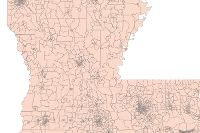

In [18]:
block_grp_item

We will use the first item for our analysis. Since the item is a Feature Layer Collection, accessing the layers property will give us a list of Feature layer objects.

In [19]:
blk_grp_lyr = block_grp_item.layers[0]

## Describe data

The [`describe_dataset`](https://developers.arcgis.com/python/api-reference/arcgis.geoanalytics.summarize_data.html#describe-dataset) method provides an overview of big data. By default, the tool outputs a [table](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#table) layer containing calculated field statistics and a dict outlining geometry and time settings for the input layer.

Optionally, the tool can output a ``feature layer`` representing a sample set of features using the ``sample_size`` parameter, or a single polygon feature layer representing the input feature layers' extent by setting the ``extent_output`` parameter to True. 

In [20]:
description = describe_dataset(input_layer=calls,
                               extent_output=True,
                               sample_size=1000,
                               output_name="Description of service calls" + str(dt.now().microsecond),
                               return_tuple=True)

{"messageCode":"BD_101051","message":"Possible issues were found while reading 'inputLayer'.","params":{"paramName":"inputLayer"}}
{"messageCode":"BD_101052","message":"Some records have either missing or invalid time values."}
{"messageCode":"BD_101054","message":"Some records have either missing or invalid geometries."}


In [21]:
description.output_json

{'datasetName': 'calls',
 'datasetSource': 'Big Data File Share - ServiceCallsOrleans',
 'recordCount': 3952898,
 'geometry': {'geometryType': 'Point',
  'sref': {'wkid': 102682, 'latestWkid': 3452},
  'countNonEmpty': 1763656,
  'countEmpty': 2189242,
  'spatialExtent': {'xmin': 0, 'ymin': 0, 'xmax': 37369000, 'ymax': 3513814}},
 'time': {'timeType': 'Instant',
  'countNonEmpty': 1763656,
  'countEmpty': 2189242,
  'temporalExtent': {'start': '2011-01-01 00:00:02.000',
   'end': '2019-08-03 23:59:09.000'}}}

In [22]:
description.sample_layer

<FeatureLayer url:"https://deldevd014.esri.com/server/rest/services/Hosted/Description_of_service_calls223782/FeatureServer/2">

In [23]:
description.sample_layer.query().sdf

,NOPD_Item,Type_,TypeText,Priority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,INSTANT_DATETIME,globalid,OBJECTID,SHAPE
0,A0247212,21,COMPLAINT OTHER,1H,37369000.0,3513814.0,01/02/2012 05:16:04 PM,01/02/2012 05:16:05 PM,01/02/2012 05:16:05 PM,01/02/2012 05:20:40 PM,NAT,NECESSARY ACTION TAKEN,052XX N Claiborne Ave,NaN,0.0,"(9.235500543E-7, -0.0000022929847665)",2012-01-02 17:16:04,{A471E188-9E41-2AA9-C46D-00771D78C616},12,"{'x': 1.8008574168558748e-05, 'y': 3.003918417..."
1,L3180018,62A,"BURGLAR ALARM, SILENT",2E,NaN,NaN,2E,3706346,518681,12/25/2018 12:38:48 AM,12/25/2018 12:42:11 AM,12/25/2018 12:47:42 AM,12/25/2018 12:58:28 AM,NaN,NaN,N,NaT,{8E68BDAF-E483-6952-ED6F-220A07FAEC2D},76,None
2,H0789414,21,COMPLAINT OTHER,1H,21.0,NaN,1H,3671292,536599,08/06/2014 07:52:05 PM,None,08/06/2014 07:52:05 PM,08/06/2014 08:04:40 PM,NaN,NaN,Y,NaT,{003975B6-5491-DDB0-A0D8-6158F8EA62E0},133,None
3,E3777812,62A,"BURGLAR ALARM, SILEN",2C,3668023.0,517302.0,05/24/2012 12:47:03 PM,05/24/2012 12:48:48 PM,05/24/2012 12:51:46 PM,05/24/2012 12:55:18 PM,NAT,NECESSARY ACTION TAKEN,005XX Dufossat St,70115.0,2.0,"(29.916803057765, -90.11110486281)",2012-05-24 12:47:03,{5ABCF635-D42E-92D4-3E1F-88F8853DCEC6},119,"{'x': -90.11111048458989, 'y': 29.916808462433..."
4,I0820718,62A,"BURGLAR ALARM, SILENT",1A,NaN,NaN,2E,3704330,554832,09/07/2018 05:52:32 PM,09/08/2018 12:52:59 AM,None,09/08/2018 01:33:43 AM,NaN,NaN,N,NaT,{BC31F407-7C92-ADA5-5FFB-2B61E04604C2},114,None
5,C1587515,21,COMPLAINT OTHER,1H,21.0,NaN,1H,3670550,539301,03/13/2015 09:42:20 PM,None,03/13/2015 09:42:20 PM,03/13/2015 09:53:24 PM,NaN,NaN,Y,NaT,{93EC1557-7D0A-539A-47A6-0EE7CEC9B645},126,None
6,E0773819,107,SUSPICIOUS PERSON,2C,3669625.0,532902.0,05/06/2019 09:07:17 AM,05/06/2019 09:08:03 AM,05/06/2019 09:10:27 AM,05/06/2019 09:20:14 AM,GOA,GONE ON ARRIVAL,107,NaN,NaN,N,2019-05-06 09:07:17,{7BDE1FC8-733C-F08E-2624-A274A5E9AC61},172,"{'x': -90.10552626485547, 'y': 29.959656351679..."
7,J3326816,21N,NOISE COMPLAINT,1E,NaN,NaN,1E,3693027,535071,10/30/2016 06:00:21 AM,10/30/2016 07:24:38 AM,10/30/2016 07:33:03 AM,10/30/2016 07:34:32 AM,NaN,NaN,N,NaT,{98B78BC8-4A35-0A0F-93E0-085E6490355C},278,None
8,L4245411,62A,"BURGLAR ALARM, SILEN",2C,3693800.0,525393.0,12/29/2011 04:47:02 PM,12/29/2011 04:48:31 PM,12/29/2011 04:56:36 PM,12/29/2011 05:26:41 PM,NAT,NECESSARY ACTION TAKEN,027XX Lawrence St,70114.0,4.0,"(29.938269364881, -90.029451676433)",2011-12-29 16:47:02,{EC51B15E-98FD-B6A1-9905-412D09B336A6},187,"{'x': -90.02945727694797, 'y': 29.938274776870..."
9,H1929011,103,DISTURBANCE (OTHER),1C,3679384.0,545506.0,08/13/2011 07:13:55 AM,08/13/2011 07:13:57 AM,08/13/2011 07:14:02 AM,08/13/2011 07:17:31 AM,NAT,NECESSARY ACTION TAKEN,015XX Sere St,70122.0,3.0,"(29.994016435986, -90.074266619976)",2011-08-13 07:13:55,{976D05C0-6D29-2618-439B-678E9EB46D37},146,"{'x': -90.0742722350555, 'y': 29.9940218586582..."


We can see some records have missing or invalid attribute values, including in the fields the manifests defines as the time and geometry values. We will visualize a sample layer on the map to understand it better.

In [24]:
m1 = gis.map()
m1

In [25]:
m1.add_layer(description.sample_layer)

The map shows that some data points have been located outside New Orleans because of missing or invalid geometries. We want to explore data points within New Orleans city limits. We will use [`clip_layer`](https://developers.arcgis.com/python/api-reference/arcgis.geoanalytics.manage_data.html#clip-layer) tool to extract only point features within the New Orleans boundary. This will remove data with missing or invalid geometries.

## Extract features within New Orleans boundary

The ``clip_layer`` method extracts input point, line, or polygon features from an ``input_layer`` that fall within the boundaries of features in a ``clip_layer``. The output layer contains a subset of features from the input layer. We will clip our input **call** feature layer to the New Orleans **blk_grp_lyr** features.

In [26]:
clip_result = clip_layer(calls, blk_grp_lyr, output_name="service calls in new Orleans" + str(dt.now().microsecond))

{"messageCode":"BD_101051","message":"Possible issues were found while reading 'inputLayer'.","params":{"paramName":"inputLayer"}}
{"messageCode":"BD_101052","message":"Some records have either missing or invalid time values."}
{"messageCode":"BD_101054","message":"Some records have either missing or invalid geometries."}


In [27]:
clip_result

<Item title:"service_calls_in_new_Orleans630022" type:Feature Layer Collection owner:admin>

In [28]:
orleans_calls = clip_result.layers[0]

In [29]:
m2 = gis.map("New Orleans")
m2

In [30]:
m2.add_layer(orleans_calls)

## Summarize data

We can use the `aggregate_points` method in the `arcgis.geoanalytics.summarize_data` submodule to group call features into individual block group features. The output polygon feature layer summarizes attribute information for all calls that fall within each block group. If no calls fall within a block group, that block group will not appear in the output.

The GeoAnalytics Tools use a [process spatial reference](https://developers.arcgis.com/rest/services-reference/process-spatial-reference.htm) during execution. Analyses with square or hexagon bins require a projected coordinate system. We'll use the World Cylindrical Equal Area projection (WKID 54034) below. All results are stored in the spatiotemporal datastore of the Enterprise in the WGS 84 Spatial Reference.

See the GeoAnalytics Documentation for a full explanation of [analysis environment settings](https://enterprise.arcgis.com/en/portal/latest/use/geoanalyticstool-useenvironmentsettings.htm).

In [31]:
arcgis.env.process_spatial_reference = 54034

In [32]:
agg_result = aggregate_points(orleans_calls, 
                              polygon_layer=blk_grp_lyr,
                              output_name="aggregate results of call" + str(dt.now().microsecond))

In [33]:
agg_result

<Item title:"aggregate_results_of_call666755" type:Feature Layer Collection owner:admin>

In [34]:
m3 = gis.map("New Orleans")
m3

In [35]:
m3.add_layer(agg_result)

In [36]:
m3.legend = True

### Analyze patterns

The [`calculate_density`](https://developers.arcgis.com/python/api-reference/arcgis.geoanalytics.analyze_patterns.html#calculate-density) method creates a density map from point features by spreading known quantities of some phenomenon (represented as attributes of the points) across the map. The result is a layer of areas classified from least dense to most dense. In this example, we will create density map by aggregating points within a bin of 1 kilometers. To learn more. please see [here](https://developers.arcgis.com/rest/services-reference/calculate-density-geoanalytics.htm)

In [37]:
cal_density = calculate_density(orleans_calls,
                                weight='Uniform',
                                bin_type='Square',
                                bin_size=1,
                                bin_size_unit="Kilometers",
                                time_step_interval=1,
                                time_step_interval_unit="Years",
                                time_step_repeat_interval=1,
                                time_step_repeat_interval_unit="Months",
                                time_step_reference=dt(2011, 1, 1),
                                radius=1000,
                                radius_unit="Meters",
                                area_units='SquareKilometers',
                                output_name="calculate density of call" + str(dt.now().microsecond))

In [38]:
cal_density

<Item title:"calculate_density_of_call124117" type:Feature Layer Collection owner:admin>

In [39]:
m4 = gis.map("New Orleans")
m4

In [40]:
m4.add_layer(cal_density)

In [41]:
m4.legend = True

### Find statistically significant hot and cold spots

The ``find_hot_spots`` tool analyzes point data and finds statistically significant spatial clustering of high (hot spots) and low (cold spots) numbers of incidents relative to the overall distribution of the data.


In [42]:
hot_spots = find_hot_spots(orleans_calls, 
                           bin_size=100,
                           bin_size_unit='Meters',
                           neighborhood_distance=250,
                           neighborhood_distance_unit='Meters',
                           output_name="get hot spot areas" + str(dt.now().microsecond))

In [43]:
hot_spots

<Item title:"get_hot_spot_areas185860" type:Feature Layer Collection owner:admin>

In [44]:
m5 = gis.map("New Orleans")
m5

In [45]:
m5.add_layer(hot_spots)

In [46]:
m5.legend = True

The darkest red features indicate areas where you can state with 99 percent confidence that the clustering of 911 call features is not the result of random chance but rather of some other variable that might be worth investigating. Similarly, the darkest blue features indicate that the lack of 911 calls is most likely not just random, but with 90% certainty you can state it is because of some variable in those locations. Features that are beige do not represent statistically significant clustering; the number of 911 calls could very likely be the result of random processes and random chance in those areas.

### Visualize other aspects of data

The `run_python_script` method executes a Python script directly in an ArcGIS GeoAnalytics server site . The script can create an analysis pipeline by chaining together multiple GeoAnalytics tools without writing intermediate results to a data store. The tool can also distribute Python functionality across the GeoAnalytics server site.

Geoanalytics Server installs a Python 3.6 environment that this tool uses. The environment includes ``Spark 2.2.0``, the compute platform that distributes analysis across multiple cores of one or more machines in your GeoAnalytics Server site. The environment includes the ``pyspark module`` which provides a collection of distributed analysis tools for data management, clustering, regression, and more. The ``run_python_script`` task automatically imports the ``pyspark module`` so you can directly interact with it.

When using the ``geoanalytics`` and ``pyspark`` packages, most functions return analysis results as Spark DataFrame memory structures. You can write these data frames to a data store or process them in a script. This lets you chain multiple geoanalytics and pyspark tools while only writing out the final result, eliminating the need to create any bulky intermediate result layers.



The **TextType** field contains the reason for the initial 911 call. Let's investigate the most frequent purposes for 911 calls in the New Orleans area by writing our own function:

In [47]:
def groupby_texttype():
    from datetime import datetime as dt
    # Calls data is stored in a feature service and accessed as a DataFrame via the layers object
    df = layers[0]
    # group the dataframe by TextType field and count the number of calls for each call type. 
    out = df.groupBy('TypeText').count()
    # Write the final result to our datastore.
    out.write.format("webgis").save("groupby_texttype" + str(dt.now().microsecond))

In the fnction above, calls layer containing 911 call points is converted to a DataFrame. pyspark can  used to group the dataframe by **TypeText** field to find the count of each category of call. The result can be saved as a feature service or other ArcGIS Enterprise layer type.

In [48]:
run_python_script(code=groupby_texttype, layers=[calls])

[{'type': 'esriJobMessageTypeInformative',
  'description': 'Executing (RunPythonScript): RunPythonScript "def groupby_texttype():\\n    from datetime import datetime as dt\\n    # Load the big data file share layer into a DataFrame.\\n    df = layers[0]\\n    # group the dataframe by TextType field and count the number of calls for each call type. \\n    out = df.groupBy(\'TypeText\').count()\\n    # Write the final result to our datastore.\\n    output_name = "groupby_texttype" + str(dt.now().microsecond)\\n    out.write.format("webgis").save(output_name)\\n\\ngroupby_texttype()" https://deldevd014.esri.com/server/rest/services/DataStoreCatalogs/bigDataFileShares_ServiceCallsOrleans/BigDataCatalogServer/calls "{"defaultAggregationStyles": false, "processSR": {"wkid": 54034}}"'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Start Time: Mon Aug 26 15:03:57 2019'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Using URL based GPRecordSet param: https://del

The result is saved as a feature layer. We can Search for the saved item using the `search()` method. Providing the search keyword same as the name we used for writing the result will retrieve the layer. 

In [49]:
grp_cat = gis.content.search('groupby_texttype')[0]

Accessing the `tables` property of the item will give us the tables object. We will then use `query()` method to read the table as spatially enabled dataframe.

In [50]:
grp_cat_df = grp_cat.tables[0].query().sdf

Sort the values in the decreasing order of the count field.

In [51]:
grp_cat_df.sort_values(by='count', ascending=False, inplace=True)

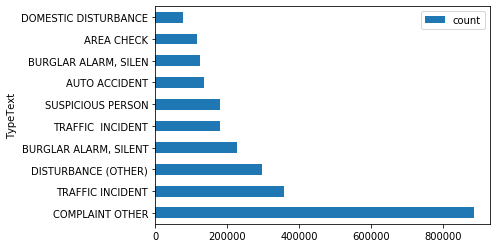

In [52]:
grp_cat_df.head(10).plot(x='TypeText', y='count', kind='barh')

We can see that **COMPLAINT OTHER** is the most common category of call followed by **TRAFFIC INCIDENTS**. 

Now we'll investigate 911 calls to investigate the most common reasons for calls within block addresses. We will define a new function to input to the ``run_python_script`` tool, this time grouping data by the **TextType** and **BLOCK_ADDRESS** attributes.

In [53]:
def grpby_cat_blkadd():
    from datetime import datetime as dt
    # Load the big data file share layer into a DataFrame
    df = layers[0]
    out = df.groupBy('TypeText', 'BLOCK_ADDRESS').count()
    out.write.format("webgis").save("grpby_cat_blkadd" + str(dt.now().microsecond))

In [54]:
run_python_script(code=grpby_cat_blkadd, layers=[calls])

[{'type': 'esriJobMessageTypeInformative',
  'description': 'Executing (RunPythonScript): RunPythonScript "def grpby_cat_blkadd():\\n    from datetime import datetime as dt\\n    # Load the big data file share layer into a DataFrame\\n    df = layers[0]\\n    out = df.groupBy(\'TypeText\', \'BLOCK_ADDRESS\').count()\\n    out.write.format("webgis").save("grpby_cat_blkadd" + str(dt.now().microsecond))\\n\\ngrpby_cat_blkadd()" https://deldevd014.esri.com/server/rest/services/DataStoreCatalogs/bigDataFileShares_ServiceCallsOrleans/BigDataCatalogServer/calls "{"defaultAggregationStyles": false, "processSR": {"wkid": 54034}}"'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Start Time: Mon Aug 26 15:17:49 2019'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Using URL based GPRecordSet param: https://deldevd014.esri.com/server/rest/services/DataStoreCatalogs/bigDataFileShares_ServiceCallsOrleans/BigDataCatalogServer/calls'},
 {'type': 'esriJobMessageTypeInforma

In [55]:
grp_cat_addr = gis.content.search('grpby_cat_blkadd')[0]

In [56]:
grp_cat_addr_df = grp_cat_addr.tables[0].query().sdf

In [57]:
grp_cat_addr_df.sort_values(by='count', ascending=False, inplace=True)

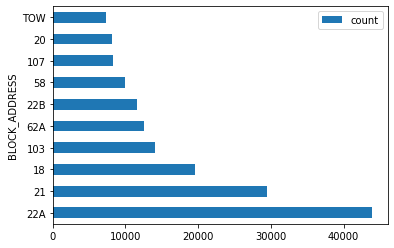

In [58]:
grp_cat_addr_df.head(10).plot(x='BLOCK_ADDRESS', y='count', kind='barh')

The chart shows that 22A block address has the highest number of incidents reported. So we want to further investigate the reason why this area had the most number of calls.

In [59]:
blk_addr_high = grp_cat_addr_df[grp_cat_addr_df['BLOCK_ADDRESS'] == '22A']

In [60]:
blk_addr_high.head()

,TypeText,BLOCK_ADDRESS,count,globalid,OBJECTID
2516001,AREA CHECK,22A,43842,{A703737A-EEF0-64D0-43A7-53BC43E0EEA1},2536366
2477875,COMPLAINT OTHER,22A,147,{4CE9300A-9C88-84F6-C19B-E63965844BAE},2478122
2477683,BUSINESS CHECK,22A,119,{DB15C4C7-1B57-4CB3-F3A5-2BA31DFE2AF1},2477922
2511367,TRAFFIC INCIDENT,22A,60,{9BA080BD-EE95-6A32-0483-82016B6FAE90},2521217
2513961,DIRECTED PATROL,22A,34,{0FAB1EB8-4524-9ECE-7AA6-3861770DEF10},2528186


In [61]:
blk_addr_high.TypeText.sort_values(ascending=False).head()

1986885         WARR STOP WITH RELEASE
676774                    WALKING BEAT
2036113    UNAUTHORIZED USE OF VEHICLE
649816                TRAFFIC INCIDENT
2226650              SUSPICIOUS PERSON
Name: TypeText, dtype: object

The result indicates the most common reason for a 911 call in the 22A Block in New Orleans is defined as **WARR STOP WITH RELEASE**.

Now let's investigate the 911 call data for temporal trends. We saw in the manifest that the **TimeCreate** field holds specific time information for one instant (in UTC time zone) using a string format: **MM/dd/yyyy hh:mm:ss a**. We can parse these strings using Python's ``datetime module`` to extract year, month, day, hour, minute, and second to perform time analyses.

Let's define a helper function to convert the **TimeCreate** attribute field string types into a date type.

In [62]:
def calls_with_datetime():
    from datetime import datetime as dt
    # Load the big data file share layer into a DataFrame
    from pyspark.sql import functions as F
    df = layers[0]
    out = df.withColumn('datetime', F.unix_timestamp('TimeCreate', 'MM/dd/yyyy hh:mm:ss a').cast('timestamp'))
    out.write.format("webgis").save("calls_with_datetime" + str(dt.now().microsecond))

In [63]:
run_python_script(code=calls_with_datetime, layers=[calls])

[{'type': 'esriJobMessageTypeInformative',
  'description': 'Executing (RunPythonScript): RunPythonScript "def calls_with_datetime():\\n    from datetime import datetime as dt\\n    # Load the big data file share layer into a DataFrame\\n    from pyspark.sql import functions as F\\n    df = layers[0]\\n    out = df.withColumn(\'datetime\', F.unix_timestamp(\'TimeCreate\', \'MM/dd/yyyy hh:mm:ss a\').cast(\'timestamp\'))\\n    out.write.format("webgis").save("calls_with_datetime" + str(dt.now().microsecond))\\n\\ncalls_with_datetime()" https://deldevd014.esri.com/server/rest/services/DataStoreCatalogs/bigDataFileShares_ServiceCallsOrleans/BigDataCatalogServer/calls "{"defaultAggregationStyles": false, "processSR": {"wkid": 54034}}"'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Start Time: Mon Aug 26 16:19:49 2019'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Using URL based GPRecordSet param: https://deldevd014.esri.com/server/rest/services/DataStoreCa

In [64]:
calls_with_datetime = gis.content.search('calls_with_datetime')[0]

In [65]:
calls_with_datetime

<Item title:"calls_with_datetime470961" type:Feature Layer Collection owner:admin>

In [66]:
calls_with_datetime_lyr = calls_with_datetime.layers[0]

We will now split the date field into year, month and hour for studying temporal trends.

In [67]:
def call_with_added_date_time_cols():
    from datetime import datetime as dt
    # Load the big data file share layer into a DataFrame
    from pyspark.sql.functions import year, month, hour
    df = layers[0]
    df = df.withColumn('year', year(df['datetime']))
    df = df.withColumn('month', month(df['datetime']))
    out = df.withColumn('hour', hour(df['datetime']))
    out.write.format("webgis").save("call_with_added_date_time_cols" + str(dt.now().microsecond))

In [68]:
run_python_script(code=call_with_added_date_time_cols, layers=[calls_with_datetime_lyr])

[{'type': 'esriJobMessageTypeInformative',
  'description': 'Executing (RunPythonScript): RunPythonScript "def call_with_added_date_time_cols():\\n    from datetime import datetime as dt\\n    # Load the big data file share layer into a DataFrame\\n    from pyspark.sql.functions import year, month, hour\\n    df = layers[0]\\n    df = df.withColumn(\'year\', year(df[\'datetime\']))\\n    df = df.withColumn(\'month\', month(df[\'datetime\']))\\n    out = df.withColumn(\'hour\', hour(df[\'datetime\']))\\n    out.write.format("webgis").save("call_with_added_date_time_cols" + str(dt.now().microsecond))\\n\\ncall_with_added_date_time_cols()" https://deldevd014.esri.com/server/rest/services/Hosted/calls_with_datetime470961/FeatureServer/0 "{"defaultAggregationStyles": false, "processSR": {"wkid": 54034}}"'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Start Time: Mon Aug 26 16:36:53 2019'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Using URL based GPRecord

In [69]:
date_time_added_item = gis.content.search('call_with_added_date_time_cols')

In [70]:
date_time_added_item[0]

<Item title:"call_with_added_date_time_cols193397" type:Feature Layer Collection owner:admin>

In [71]:
date_time_added_lyr = date_time_added_item[0].layers[0]

In [72]:
def grp_calls_by_month():
    from datetime import datetime as dt
    # Load the big data file share layer into a DataFrame
    df = layers[0]
    out = df.groupBy('month').count()
    out.write.format("webgis").save("grp_calls_by_month" + str(dt.now().microsecond))

In [73]:
run_python_script(code=grp_calls_by_month, layers=[date_time_added_lyr])

[{'type': 'esriJobMessageTypeInformative',
  'description': 'Executing (RunPythonScript): RunPythonScript "def grp_calls_by_month():\\n    from datetime import datetime as dt\\n    # Load the big data file share layer into a DataFrame\\n    df = layers[0]\\n    out = df.groupBy(\'month\').count()\\n    out.write.format("webgis").save("grp_calls_by_month" + str(dt.now().microsecond))\\n\\ngrp_calls_by_month()" https://deldevd014.esri.com/server/rest/services/Hosted/call_with_added_date_time_cols193397/FeatureServer/0 "{"defaultAggregationStyles": false, "processSR": {"wkid": 54034}}"'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Start Time: Mon Aug 26 16:40:16 2019'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Using URL based GPRecordSet param: https://deldevd014.esri.com/server/rest/services/Hosted/call_with_added_date_time_cols193397/FeatureServer/0'},
 {'type': 'esriJobMessageTypeInformative',
  'description': '{"messageCode":"BD_101028","message":

In [74]:
month = gis.content.search('grp_calls_by_month')[0]

In [75]:
grp_month = month.tables[0]

In [76]:
df_month = grp_month.query().sdf

In [77]:
df_month

,month,count,globalid,OBJECTID
0,4.0,164835,{B85CF9B6-A0B7-0CDB-2BD4-EE75CC1D8B7D},103
1,7.0,169707,{9EDBD2EF-DC5E-FA4C-36B9-886AE09BEEB6},108
2,12.0,120340,{F55F4B76-040A-B393-157B-84A13AA90D34},25
3,2.0,150248,{1985235D-E1C1-F681-BDFC-4551A55A476A},175
4,9.0,120086,{9F6CB958-8506-C6CD-13DC-7E39B13E1D02},90
5,6.0,165339,{F51867CF-B370-11D7-106F-3BEA57712EAE},50
6,1.0,161162,{667184E7-5446-EFC4-DF05-642A5F93B1C9},44
7,3.0,166684,{24E0D747-1DF5-FB24-C5B5-4CACC874DB3B},52
8,5.0,171744,{3BEDD3BF-726B-D044-5B75-FDF1D088FFFD},67
9,NaN,2189242,{143D6439-ACBD-FD65-A324-1C26B8F7E75F},43


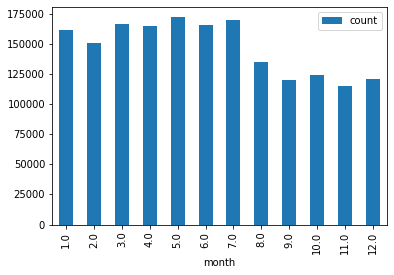

In [78]:
df_month.dropna().sort_values(by='month').plot(x='month', y='count', kind='bar')

It shows that calls are most frequent in the earlier months of the year.

In [79]:
def grp_calls_by_hour():
    from datetime import datetime as dt
    # Load the big data file share layer into a DataFrame
    df = layers[0]
    out = df.groupBy('hour').count()
    out.write.format("webgis").save("grp_calls_by_hour" + str(dt.now().microsecond))

In [80]:
run_python_script(code=grp_calls_by_hour, layers=[date_time_added_lyr])

[{'type': 'esriJobMessageTypeInformative',
  'description': 'Executing (RunPythonScript): RunPythonScript "def grp_calls_by_hour():\\n    from datetime import datetime as dt\\n    # Load the big data file share layer into a DataFrame\\n    df = layers[0]\\n    out = df.groupBy(\'hour\').count()\\n    out.write.format("webgis").save("grp_calls_by_hour" + str(dt.now().microsecond))\\n\\ngrp_calls_by_hour()" https://deldevd014.esri.com/server/rest/services/Hosted/call_with_added_date_time_cols193397/FeatureServer/0 "{"defaultAggregationStyles": false, "processSR": {"wkid": 54034}}"'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Start Time: Mon Aug 26 16:49:37 2019'},
 {'type': 'esriJobMessageTypeInformative',
  'description': 'Using URL based GPRecordSet param: https://deldevd014.esri.com/server/rest/services/Hosted/call_with_added_date_time_cols193397/FeatureServer/0'},
 {'type': 'esriJobMessageTypeInformative',
  'description': '{"messageCode":"BD_101028","message":"Sta

In [81]:
hour = gis.content.search('grp_calls_by_hour')[0]

In [82]:
grp_hour = hour.tables[0]

In [83]:
df_hour = grp_hour.query().sdf

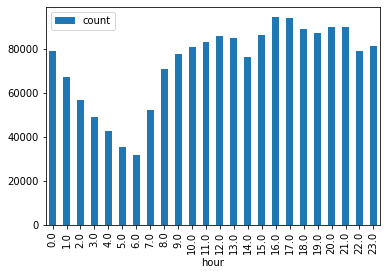

In [84]:
df_hour.dropna().sort_values(by='hour').plot(x='hour', y='count', kind='bar')

The chart above shows frequency of calls per hour of the day. We can see that there is a high frequency of calls during 4-5 p.m

## Conclusion

We have shown spatial patterns in distribuition of emergency calls and the need of including temporal trends in the analysis. There is an obvious variation in the monthly, weekly, daily and even hourly distribution of service calls and this should be accounted for in further analysis or allocation of resources.